### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 22}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import tensorflow as tf

import sequtils as su
import seq

### Create random genomes as toy data 

In [2]:
N = 4           # number of genomes
tile_size = 20  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
genomes = seq.getRandomGenomes(N, tile_size, genome_sizes)

In [3]:
genomes

[['ACTAAGGGCTAAAAGTATGGTTTTTCTTTGACATCTTAGGTTACGGTTTAATGTCTTTTGAATCTATAAACTGCCGTGGCTCAACAAATCGCACGACTTCGGCCTCCGTGAAGTCGACCACAAAGCGTGGTCACGTGGGCCTACTCAAGGGCCAGTGACGAGCTCCGTGGACTCCAGAAGATGAAGCACCAAAAGTATTTACACGCAGGA',
  'GCGTCAGAAAAATTTACTAATGGTAGAACAAGTAGTAACCCAGGGGTCTGTGCATAGTCTAAACGGAGGCATACACATGTCGGGGGTGTCTGGTATCTTC'],
 ['CCTTACCCCCGCACAGCAAGCCCCGCGTCC',
  'CCCTACGAGGAAATGTCAACTGGAATATGGGCTCGGTATGATGAACCCAAGAGCCACACAGGCGGTGGCCACAAGAGAACGAAACGGCTCGTTCCAGCAGGAGATTGCGGAAATGTAACCTGGCTTCGCCCTTACACCGGATGATAGATCCGGCTTGATCGATAGCCTGGGGTACGTAATACAACATTATAGCTTCCGCGAACGGTTTCGTATGGCTCAG',
  'ATCCACAGACGCGAAATCTCCGCGTTCATGACTTCAGCAAGTGTACCAAACATAGACGTCTTAATGAAAGTGAATGACGACCTTCCTAATATTTATAGTCAAGATATAGCCAACAGTCCAAGGTGTTGCTGCTACCCACAAGGACCATTC'],
 ['CTACCGCCGGGAGCTGTGTGCACCCATAAACCTCGATTTCGAATGCGAGCGTATTCCCATTTATTCGACCCGGCGTAAGCCGCACCACTCATCTAATTTCGCGGTCCACTGCTTCCCATATAGAAAGGTAGGTGTATGCATTATCTGATAGCAATGGGAAGCCGTTTTAGGAAGTCGAACATAGCGTAAGCGGAGGAAACCTCCGGCTGAGGCCCATGCAACTATACCGC',
  'GCATGGAGCGATGATCCCC

In [4]:
Q = seq.backGroundAAFreqs(genomes, True)
# set a small probability for 0-th character (missing aa) to avoid numerical error
Q[0] = 0.0001
Q /= Q.sum()
Q

background freqs:  2840.0 *
  0.0000
C 0.0313
K 0.0324
E 0.0310
W 0.0180
T 0.0609
G 0.0630
Y 0.0370
A 0.0627
I 0.0514
N 0.0275
V 0.0606
H 0.0370
S 0.0894
D 0.0299
F 0.0331
M 0.0194
R 0.0933
L 0.0880
P 0.0634
Q 0.0257
* 0.0451


array([9.9989986e-05, 3.1334892e-02, 3.2391120e-02, 3.0982813e-02,
       1.7955950e-02, 6.0909394e-02, 6.3021861e-02, 3.6968127e-02,
       6.2669784e-02, 5.1403303e-02, 2.7462039e-02, 6.0557317e-02,
       3.6968127e-02, 8.9427665e-02, 2.9926581e-02, 3.3095278e-02,
       1.9364258e-02, 9.3300514e-02, 8.8019356e-02, 6.3373931e-02,
       2.5701651e-02, 4.5065910e-02], dtype=float32)

#### Read in the genome

In [5]:
batch_size = 2  # constrained by RAM and gradient descent performance

X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
X.shape

(2, 4, 6, 20, 22)

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 22 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{22}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{21} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 22 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{21} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [6]:
U = 2 # number of profiles to train
k = 3 # length of profiles

In [15]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        P_logit_init = tf.random.normal([k, alphabet_size, units],
                                    stddev=1.,
                                    dtype=tf.float32,
                                    seed=1)
        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q

    def getP(self):
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def call(self, X):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        R = tf.math.log(P/Q2)

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                         padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S

    # custom loss
    def loss(self, S):
        L1 = tf.reduce_sum(S)
        return L1

    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S = self.call(X)
            L = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X):
        self.opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        for i in range(10):
            self.train_step(X)
            if i%100 == 0:
                S = self(X)
                L = self.loss(S)
                print("loss=", L)

In [16]:
specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

### Training

In [17]:
specProModel.train(X)

loss= tf.Tensor(44.672707, shape=(), dtype=float32)


In [18]:
P = specProModel.getP()
P

<tf.Tensor: shape=(3, 22, 2), dtype=float32, numpy=
array([[[0.03540362, 0.00621754],
        [0.11979353, 0.05192546],
        [0.08301315, 0.03391496],
        [0.02579159, 0.00638013],
        [0.02279522, 0.01840889],
        [0.00896827, 0.00634902],
        [0.03063946, 0.05137086],
        [0.00775049, 0.1074899 ],
        [0.01216878, 0.03489775],
        [0.05292035, 0.0481878 ],
        [0.02760285, 0.01760041],
        [0.008845  , 0.11022015],
        [0.05242123, 0.01713062],
        [0.00432009, 0.00944972],
        [0.01287324, 0.01184753],
        [0.23534803, 0.00683263],
        [0.00178908, 0.01461949],
        [0.00745366, 0.02257584],
        [0.01405564, 0.04245442],
        [0.02160924, 0.02321611],
        [0.20044881, 0.00294867],
        [0.01398855, 0.35596213]],

       [[0.00734191, 0.13321282],
        [0.08238347, 0.00758329],
        [0.01164624, 0.15153775],
        [0.00996538, 0.06966911],
        [0.03061597, 0.01181096],
        [0.02379844, 0.01656

### Visualize resulting profiles as sequence logos


In [19]:
dfs = su.makeDFs(P.numpy())


In [20]:
import logomaker

Text(0, 0.5, 'information (bits)')

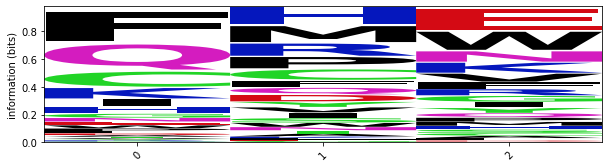

In [27]:
logo = logomaker.Logo(dfs[0], vpad=.1, width=1)
logo.style_xticks(anchor=0, spacing=1, rotation=45)
logo.ax.set_ylabel('information (bits)')

In [14]:
# dataset = tf.data.Dataset.from_tensor_slices([X])